In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

In [2]:
spark = SparkSession.builder.getOrCreate()

### Loading

In [3]:
comments = spark.read.load('../data/sample.parquet')

In [4]:
comments.limit(10).toPandas().head(3)

,distinguished,retrieved_on,gilded,edited,id,parent_id,flair_text,author,score,ups,...,author_flair_context,flair_css_class,subreddit,subreddit_id,score_hidden,stickied,link_id,controversiality,body,archived
0,None,1429291671,0,-1,c595rma,t1_c595qio,None,NoNeedForAName,1,1,...,None,None,law,t5_2qh9k,False,None,t3_vysbf,0,"The fear that it's a ""grass is always greener""...",True
1,None,1429291672,0,-1,c595rqe,t3_w0bkb,None,Duderino316,2,2,...,None,None,mexico,t5_2qhv7,False,None,t3_w0bkb,0,Upvote!,True
2,None,1429291676,0,-1,c595rwc,t1_c595gbw,None,emshlaf,2,2,...,None,None,WTF,t5_2qh61,False,None,t3_vzvlq,0,"It's real, it's in New York City.",True


### Cleaning & Preparation

First, we parse the column `create_utc` into a real date.

In [5]:
comments = comments.withColumn('created', func.from_unixtime(comments['created_utc'], 'yyyy-MM-dd HH:mm:ss.SS').cast(DateType()))

In [6]:
# comments = comments.limit(60000)
comments.registerTempTable("comments")

### General Information

##### Dataset

In [7]:
print("There is a total of {} comments in the dataset.".format(comments.count()))

There is a total of 6181548 comments in the dataset.


In [ ]:
dates_extrema = spark.sql("""
    SELECT MIN(created), MAX(created) FROM comments
""").collect()

earliest_date = dates_extrema[0][0]
latest_date = dates_extrema[0][1]

print("The dataset starts on the {} and ends on the {}.".format(earliest_date, latest_date))

##### Top-Level Comments

It is possible to identify top-level comments easily by using the `parent_id` attribute. If the `parent_id` attribute starts with `t1_`, then it means that the parent is another message. If the `parent_id` attribute starts with `t3_`, then its parent is a post and therefore it is a top-level comment. Another possible technique is to use `link_id` which is the id of the related post. By checking wether `parent_id == link_id`. Since equality is faster to check than using the `LIKE` operator, we will use the later technique.

In [9]:
top_level_comments = spark.sql("""
    SELECT *
    FROM comments
    WHERE parent_id=link_id
""")

In [10]:
lower_level_comments = spark.sql("""
    SELECT *
    FROM comments
    WHERE parent_id!=link_id
""")

In [11]:
print("There are {} top-level comments and {} lower level comments in this dataset.".format(
    top_level_comments.count(),
    lower_level_comments.count()
))

There are 2447182 top-level comments and 3734366 lower level comments in this dataset.


Now, only seeing the immediate parent of a post is not practical. We would like to view all the parents and understand the depth of a comment.

In [12]:
comments_iter = comments.withColumn('depth', func.lit(0)).withColumn('parent_ids', func.lit(''))

##### Posts

Unfortunately, the dataset only contains comments and not posts. However, we still have some information on the posts, via the `link_id` attribute of the comments.

In [13]:
posts = spark.sql("""
    SELECT 
        link_id AS id,  
        COUNT(*) AS count_of_comments, 
        FIRST(subreddit) AS subreddit,
        FIRST(subreddit_id) AS subreddit_id,
        MIN(created) AS created,
        MIN(created_utc) AS created_utc,
        COUNT(DISTINCT author) AS count_of_participants
    FROM comments
    GROUP BY link_id
    SORT BY created
""")

In [14]:
posts.registerTempTable("posts")

Now, we can compute some more sophisticated metrics. For instance, what are the top 10 posts in terms of number of comments?

In [15]:
spark.sql("""
    SELECT *
    FROM posts
    ORDER BY count_of_comments DESC
    LIMIT 10
""").show()

+---------+-----------------+-----------------+------------+----------+-----------+---------------------+
|       id|count_of_comments|        subreddit|subreddit_id|   created|created_utc|count_of_participants|
+---------+-----------------+-----------------+------------+----------+-----------+---------------------+
| t3_d14xg|              739|             blog|    t5_2qh49|2010-08-15| 1281844107|                   23|
|t3_28sluw|              284|  jerktalkdiamond|    t5_2w9v1|2014-06-22| 1403447424|                    8|
|t3_2q36z6|              263|millionairemakers|    t5_34njs|2014-12-22| 1419273623|                  244|
|t3_60bql0|              236|          xboxone|    t5_2xbci|2017-03-19| 1489952544|                  218|
|t3_5sapal|              206|              nfl|    t5_2qmg3|2017-02-06| 1486337751|                  183|
|t3_5ac0p2|              199|          pokemon|    t5_2qmeb|2016-10-31| 1477921192|                  194|
|t3_5at9kg|              176|         baseball

##### Subreddits

In [16]:
subreddits = spark.sql("""
    SELECT 
        subreddit_id AS id,
        FIRST(subreddit) AS name,
        COUNT(*) AS count_of_comments,
        COUNT(DISTINCT link_id) AS count_of_posts, 
        MIN(created) AS created,
        MIN(created_utc) AS created_utc
    FROM comments
    GROUP BY subreddit_id
    SORT BY created
""")

In [17]:
subreddits.registerTempTable("subreddits")

In [18]:
spark.sql("""
    SELECT *
    FROM subreddits
    ORDER BY count_of_posts DESC
    LIMIT 10
""").show()

+--------+---------------+-----------------+--------------+----------+-----------+
|      id|           name|count_of_comments|count_of_posts|   created|created_utc|
+--------+---------------+-----------------+--------------+----------+-----------+
|t5_2qh1i|      AskReddit|           569779|        278766|2008-02-12| 1202821148|
|t5_2qh33|          funny|           128159|         88827|2008-03-05| 1204693008|
|t5_2qh0u|           pics|           120180|         75243|2008-02-10| 1202654589|
|t5_2rfxx|leagueoflegends|            95928|         66393|2010-04-26| 1272257177|
|t5_2cneq|       politics|           103448|         59054|2007-08-07| 1186515358|
|t5_2qh03|         gaming|            83138|         57518|2007-11-10| 1194696191|
|t5_2qh61|            WTF|            72097|         46421|2008-03-22| 1206220877|
|t5_2s7tt|  AdviceAnimals|            68235|         46254|2010-12-08| 1291833473|
|t5_2qh1e|         videos|            66621|         37389|2008-04-01| 1207023443|
|t5_

##### Users



In [19]:
users = spark.sql("""
    SELECT 
        author AS username,
        COUNT(*) AS count_of_comments,
        SUM(score) AS karma,
        AVG(score) AS avg_score,
        MIN(created) AS created,
        MIN(created_utc) AS created_utc
    FROM comments
    WHERE author!='[deleted]'
    GROUP BY author
    SORT BY created
""")

In [20]:
users.registerTempTable("users")

In [21]:
spark.sql("""
    SELECT *
    FROM users
    ORDER BY karma DESC
    LIMIT 10
""").show()

+---------------+-----------------+-----+------------------+----------+-----------+
|       username|count_of_comments|karma|         avg_score|   created|created_utc|
+---------------+-----------------+-----+------------------+----------+-----------+
|  AutoModerator|            28896|30039|1.0395556478405317|2012-03-09| 1331268657|
|    Hal_E_Lujah|                1|19066|           19066.0|2017-01-22| 1485098605|
|          eggre|                4|14044|            3511.0|2013-12-25| 1388005245|
|cool_creeper500|                6|13317|            2219.5|2016-08-21| 1471779618|
|    kernunnos77|               30|12059|401.96666666666664|2012-09-12| 1347481914|
|    MyOnlyAlias|                4|11596|            2899.0|2012-12-28| 1356718918|
| kungfumilhouse|                3|11496|            3832.0|2015-11-11| 1447211703|
|      jdog_dude|                1|11163|           11163.0|2016-12-20| 1482237133|
|   PepeInfiniti|                1|11070|           11070.0|2016-12-18| 1482

### High-Level Metrics

##### Number of Comments per day

In [26]:
comments_per_day = spark.sql("""
    SELECT created, COUNT(*)
    FROM comments
    GROUP BY created
    ORDER BY created
""")

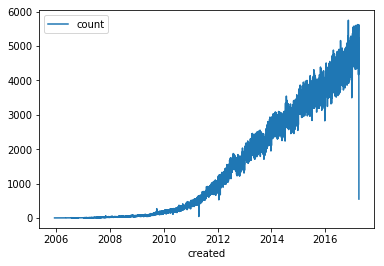

In [27]:
comments_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'}).plot()

##### Number of [Removed] comments per day

In [28]:
removed_comments_per_day = spark.sql("""
    SELECT created, COUNT(*)
    FROM comments
    WHERE UPPER(body)='[REMOVED]'
    GROUP BY created
    ORDER BY created
""")

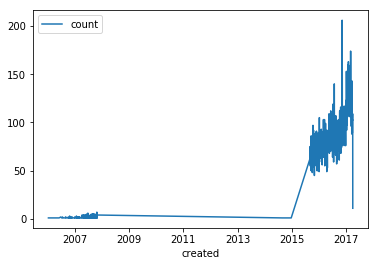

In [29]:
_ = removed_comments_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'}).plot()

##### Number of Controversial Comments per day

In [30]:
controversial_comments_per_day = spark.sql("""
    SELECT created, COUNT(*)
    FROM comments
    WHERE controversiality=1
    GROUP BY created
    ORDER BY created
""")

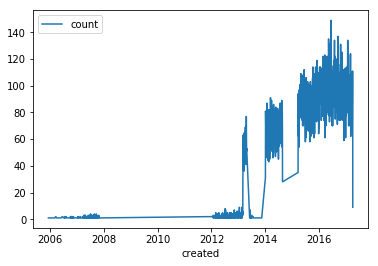

In [31]:
_ = controversial_comments_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'}).plot()

##### Average Score per day

In [32]:
avg_score_per_day = spark.sql("""
    SELECT created, AVG(score)
    FROM comments
    GROUP BY created
    ORDER BY created
""")

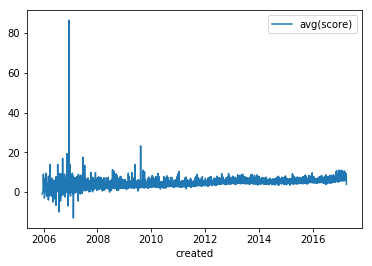

In [33]:
_ = avg_score_per_day.toPandas().set_index('created').plot()

##### Total Score per Day

In [34]:
total_score_per_day = spark.sql("""
    SELECT created, SUM(score)
    FROM comments
    GROUP BY created
    ORDER BY created
""")

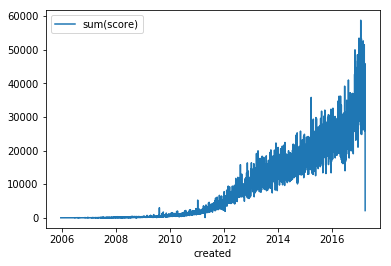

In [35]:
_ = total_score_per_day.toPandas().set_index('created').plot()

##### Removed Comments per Day

In [36]:
removed_comments_per_day = spark.sql("""
    SELECT created, COUNT(*)
    FROM comments
    WHERE body='[removed]'
    GROUP BY created
    ORDER BY created
""")

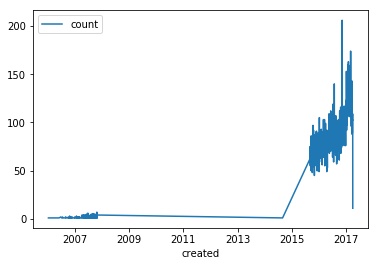

In [37]:
_ = removed_comments_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'}).plot()

##### Gold per day

In [38]:
gold_per_day = spark.sql("""
    SELECT created, SUM(gilded)
    FROM comments
    GROUP BY created
    ORDER BY created
""")
gold_per_day_pd = gold_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'})

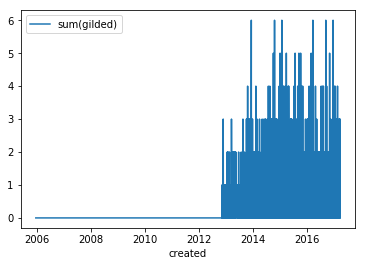

In [39]:
gold_per_day_pd.plot()